In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

import sys
sys.path.append('../..')

from utils.workflow import WorkflowModel
import utils.plotting as plotting
from utils.eval import eval_predictions

2025-12-18 11:40:06.807244: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
Using backend: tensorflow
Other supported backends: tensorflow.compat.v1, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Enable just-in-time compilation with XLA.



Set the default float type to float64


In [2]:
df = pd.read_csv("../../data/sir-am-7d.csv")
df[:5]

,I
0,1185.428571
1,1309.714286
2,1454.857143
3,1627.428571
4,1838.428571


In [3]:
I_data = df["I"].to_numpy()
I_data[:5]

array([1185.42857143, 1309.71428571, 1454.85714286, 1627.42857143,
       1838.42857143])

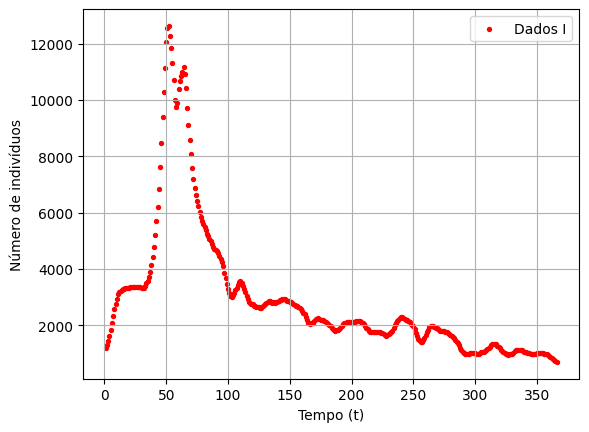

In [4]:
plotting.plot_incidence_data(I_data, "incidence-data-am-2023")

In [5]:
t_0, t_f = 0, len(I_data) - 1
N = 8116132 # population size
data_t = np.linspace(t_0, t_f, len(I_data))

In [6]:
model = WorkflowModel(t_0, t_f, I_data, data_t, N, 1/7, 
    activation="tanh",
    n_hidden_layers=3,
    hidden_layer_size=80, 
    scaling="min/max",
    adaptative_wdata=False,
    early_stopping=False)

[<deepxde.icbc.initial_conditions.IC object at 0x7f0189c80290>, <deepxde.icbc.initial_conditions.IC object at 0x7f0189b99a50>, <deepxde.icbc.boundary_conditions.PointSetBC object at 0x7f0180a8ed50>]
Compiling model...
'compile' took 0.020253 s



2025-12-18 11:40:13.688766: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
I0000 00:00:1766068813.689449  293779 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2581 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1650, pci bus id: 0000:01:00.0, compute capability: 7.5


In [7]:
model.train()

Training model...



2025-12-18 11:40:16.693806: I external/local_xla/xla/service/service.cc:163] XLA service 0x560e17b74760 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-12-18 11:40:16.693823: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce GTX 1650, Compute Capability 7.5
2025-12-18 11:40:16.709457: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-12-18 11:40:16.780042: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91002
I0000 00:00:1766068817.126913  293779 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


Step      Train loss                                            Test loss                                             Test metric
0         [2.96e-03, 5.22e-02, 4.62e+05, 1.69e-03, 1.90e+00]    [1.26e-03, 5.13e-02, 4.62e+05, 1.69e-03, 1.90e+00]    []  
100       [2.02e-04, 2.83e-06, 4.23e+05, 4.89e-03, 4.76e-02]    [2.02e-04, 2.83e-06, 4.23e+05, 4.89e-03, 4.76e-02]    []  
200       [8.06e-05, 5.36e-05, 4.01e+05, 5.28e-03, 4.71e-02]    [8.07e-05, 5.36e-05, 4.01e+05, 5.28e-03, 4.71e-02]    []  
300       [6.92e-05, 6.32e-05, 3.81e+05, 5.27e-03, 4.72e-02]    [6.93e-05, 6.32e-05, 3.81e+05, 5.27e-03, 4.72e-02]    []  
400       [6.74e-05, 6.48e-05, 3.61e+05, 5.27e-03, 4.72e-02]    [6.74e-05, 6.48e-05, 3.61e+05, 5.27e-03, 4.72e-02]    []  
500       [6.67e-05, 6.54e-05, 3.42e+05, 5.27e-03, 4.72e-02]    [6.67e-05, 6.54e-05, 3.42e+05, 5.27e-03, 4.72e-02]    []  
600       [6.64e-05, 6.56e-05, 3.25e+05, 5.27e-03, 4.72e-02]    [6.64e-05, 6.56e-05, 3.25e+05, 5.27e-03, 4.72e-02]    []  
700      

(<deepxde.model.LossHistory at 0x7f018085ef10>,
 <deepxde.model.TrainState at 0x7f018085d090>)

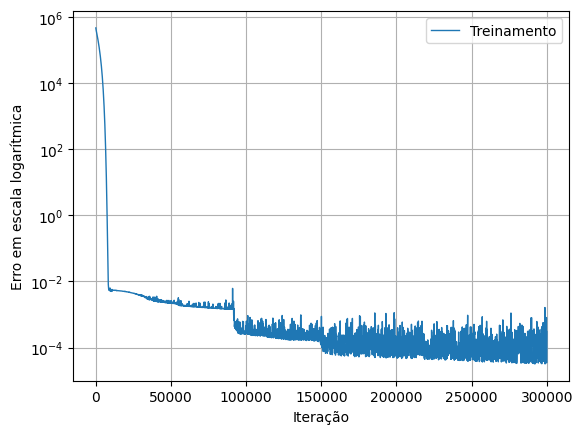

In [8]:
plotting.plot_losshistory(model.losshistory, "loss-am-2023")

In [9]:
test_t = np.linspace(t_0, t_f, 50)
pred = model.predict(test_t)

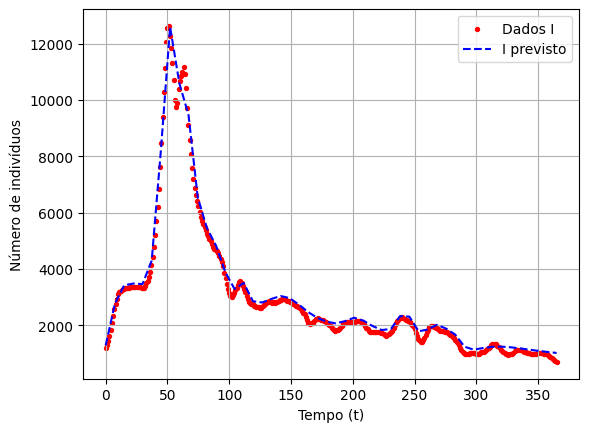

In [10]:
plotting.plot_incidence_results(I_data, data_t, pred[:,1:2], test_t, "incidence-results-am-2023")

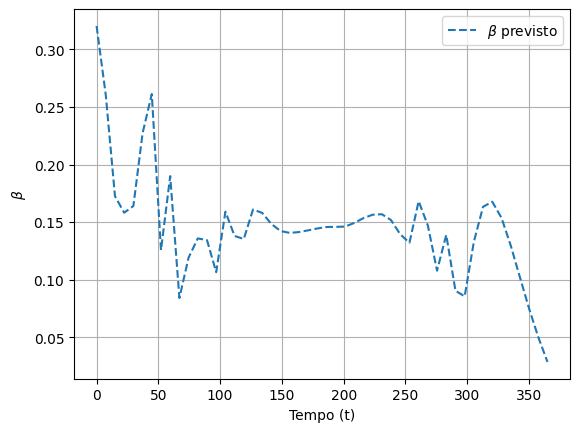

In [11]:
plotting.plot_beta(pred[:,2], test_t, "beta-am-2023")

In [12]:
pred_eval = model.predict(data_t)
eval_predictions(I_data.reshape(-1,1), pred_eval[:,1].reshape(-1,1), ["I"])

,compartiment,MSE,L2,L-infinity
0,I,26485.689388,0.04268,446.172636


In [ ]:
model.formated_total_training_time

In [ ]:
spearmanr()